# RMSE Evaluation and Comparison of TB X-ray Classification Models

This notebook compares the original and finetuned models by measuring their Root Mean Square Error (RMSE) on both the original dataset and new test dataset.

In [1]:
# Setup and Import Libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import seaborn as sns

sys.path.append('..')
from attention_model import SimpleAttentionCNN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 1. Model Paths and Loading

In [2]:
# Define paths
ORIGINAL_MODEL_PATH = "../model/tb_chest_xray_attention_best.pt"
FINETUNED_MODEL_PATH = "../finetuning/tb_chest_xray_refined_20250318_034728.pt"
ORIGINAL_DATASET_DIR = "../model/tuberculosis-dataset"
NEW_TEST_DATA_PATH = "../Testing/test_dataset"
METADATA_PATH = "../Testing/test_dataset/MetaData.csv"

# Check if the files and directories exist
print(f"Original model exists: {os.path.exists(ORIGINAL_MODEL_PATH)}")
print(f"Finetuned model exists: {os.path.exists(FINETUNED_MODEL_PATH)}")
print(f"Original dataset directory exists: {os.path.exists(ORIGINAL_DATASET_DIR)}")
print(f"New test dataset directory exists: {os.path.exists(NEW_TEST_DATA_PATH)}")
print(f"Metadata CSV exists: {os.path.exists(METADATA_PATH)}")

# Load model
def load_model(model_path):
    model = SimpleAttentionCNN().to(device)
    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
        print(f"Successfully loaded model from {model_path}")
        return model
    except Exception as e:
        print(f"Error loading model from {model_path}: {e}")
        return None

# Load both models
original_model = load_model(ORIGINAL_MODEL_PATH)
finetuned_model = load_model(FINETUNED_MODEL_PATH)

# Set models to evaluation mode
if original_model:
    original_model.eval()
if finetuned_model:
    finetuned_model.eval()

Original model exists: True
Finetuned model exists: True
Original dataset directory exists: True
New test dataset directory exists: True
Metadata CSV exists: True


C:\Users\dell\AppData\Local\Temp\ipykernel_13692\2314023169.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=de

Successfully loaded model from ../model/tb_chest_xray_attention_best.pt
Successfully loaded model from ../finetuning/tb_chest_xray_refined_20250318_034728.pt


## 2. Prepare Original Test Dataset

In [3]:
# Create original test dataset with test split
def prepare_original_test_dataset(test_split=0.3, random_seed=42):
    """
    Creates a test dataset from the original data using a consistent split
    """
    # Load all images and labels - using the same approach as in tuberculosis-CNN-model.ipynb
    all_images = []
    all_labels = []
    all_paths = []
    IMAGE_SIZE = 256
    
    normal_dir = os.path.join(ORIGINAL_DATASET_DIR, "Normal")
    tb_dir = os.path.join(ORIGINAL_DATASET_DIR, "Tuberculosis")
    
    # Load Normal images (label = 0) - same loading process as original training
    for fname in os.listdir(normal_dir):
        if not fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue
        filepath = os.path.join(normal_dir, fname)
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
            all_images.append(img)
            all_labels.append(0)
            all_paths.append(filepath)
    
    # Load Tuberculosis images (label = 1)
    for fname in os.listdir(tb_dir):
        if not fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue
        filepath = os.path.join(tb_dir, fname)
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
            all_images.append(img)
            all_labels.append(1)
            all_paths.append(filepath)
    
    all_images = np.array(all_images)
    all_labels = np.array(all_labels)
    all_paths = np.array(all_paths)
    
    print(f"Loaded {len(all_images)} images")
    print(f"Class distribution: {np.sum(all_labels == 0)} Normal, {np.sum(all_labels == 1)} TB")
    
    # Use exact same train_test_split as in the original model training
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test, paths_train, paths_test = train_test_split(
        all_images, all_labels, all_paths, test_size=test_split, random_state=random_seed
    )
    
    # Convert from [0,255] -> [0,1] for testing (matching original preprocessing)
    X_test = X_test.astype('float32') / 255.0
    
    # Create a PyTorch dataset from these arrays
    class OriginalTestDataset(Dataset):
        def __init__(self, images, labels, paths, transform=None):
            self.images = images  # Already preprocessed
            self.labels = labels
            self.paths = paths
            self.transform = transform
        
        def __len__(self):
            return len(self.images)
        
        def __getitem__(self, idx):
            img = self.images[idx]  # Shape: (H, W)
            label = self.labels[idx]
            path = self.paths[idx]
            
            # Convert to tensor
            if self.transform:
                # Convert to PIL for transforms
                pil_img = Image.fromarray((img * 255).astype('uint8'), mode='L')
                img_tensor = self.transform(pil_img)
            else:
                img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0)  # Add channel dim
            
            return img_tensor, torch.tensor(label, dtype=torch.float32), path
    
    # Create transform matching the one used in original testing
    test_transforms = T.Compose([
        T.ToTensor()  # Images are already resized and normalized
    ])
    
    # Create and return the test dataset
    test_dataset = OriginalTestDataset(X_test, y_test, paths_test, transform=test_transforms)
    
    print(f"Created original test dataset with {len(test_dataset)} images")
    print(f"Class distribution: {np.sum(y_test == 0)} Normal, {np.sum(y_test == 1)} TB")
    
    return test_dataset

# Create original test dataset and dataloader
original_test_dataset = prepare_original_test_dataset()
original_test_dataloader = DataLoader(original_test_dataset, batch_size=32, shuffle=False)

Loaded 4200 images
Class distribution: 3500 Normal, 700 TB
Created original test dataset with 1260 images
Class distribution: 1043 Normal, 217 TB


## 3. Prepare New Test Dataset

In [4]:
def load_new_test_dataset():
    """Load the new test dataset from MetaData.csv"""
    metadata_csv = METADATA_PATH
    images_dir = os.path.join(NEW_TEST_DATA_PATH, "Chest-X-Ray", "image")
    
    if not os.path.isfile(metadata_csv):
        print(f"MetaData CSV not found: {metadata_csv}")
        return None
        
    if not os.path.isdir(images_dir):
        print(f"New test images directory not found: {images_dir}")
        # Try to find images directory by searching subdirectories
        base_dir = NEW_TEST_DATA_PATH
        for root, dirs, _ in os.walk(base_dir):
            for dir_name in dirs:
                if 'image' in dir_name.lower():
                    potential_dir = os.path.join(root, dir_name)
                    if any(f.lower().endswith(('.png', '.jpg', '.jpeg')) for f in os.listdir(potential_dir)):
                        images_dir = potential_dir
                        print(f"Found alternative images directory: {images_dir}")
                        break
            if os.path.isdir(images_dir) and 'image' in os.path.basename(images_dir).lower():
                break
        
        if not os.path.isdir(images_dir):
            return None
    
    class NewTestDataset(Dataset):
        """Dataset class for the new test images."""
        def __init__(self, metadata_path, images_dir, transform=None):
            self.transform = transform or T.Compose([
                T.Resize((256, 256)),
                T.ToTensor()
            ])
            self.image_paths = []
            self.labels = []
            
            try:
                # Read the CSV
                df = pd.read_csv(metadata_path)
                
                # Check file extensions in the directory to determine the correct one
                extensions = ['.png', '.jpg', '.jpeg']
                extension_check = None
                
                # Sample a file to check extension
                sample_files = os.listdir(images_dir)[:5]
                for file in sample_files:
                    for ext in extensions:
                        if file.lower().endswith(ext):
                            extension_check = ext
                            break
                    if extension_check:
                        break
                
                if not extension_check:
                    extension_check = '.png'  # Default
                
                # Process each row in metadata
                for _, row in df.iterrows():
                    id_val = str(row['id'])
                    label = int(row['ptb'])  # ptb=1 is TB positive, ptb=0 is Normal
                    
                    # Check for matching image file
                    img_filename = f"{id_val}{extension_check}"
                    img_path = os.path.join(images_dir, img_filename)
                    
                    # If direct match not found, try searching
                    if not os.path.isfile(img_path):
                        for file in os.listdir(images_dir):
                            if id_val in file and file.lower().endswith(tuple(extensions)):
                                img_path = os.path.join(images_dir, file)
                                break
                    
                    if os.path.isfile(img_path):
                        self.image_paths.append(img_path)
                        self.labels.append(label)
                
                print(f"Loaded {len(self.image_paths)} new test images")
                print(f"Class distribution: {self.labels.count(0)} Normal, {self.labels.count(1)} TB")
                
            except Exception as e:
                print(f"Error loading new test data: {e}")
        
        def __len__(self):
            return len(self.image_paths)
        
        def __getitem__(self, idx):
            img_path = self.image_paths[idx]
            label = self.labels[idx]
            
            try:
                # Read the image
                img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img_gray is None:
                    raise FileNotFoundError(f"Could not read image: {img_path}")
                
                # Convert to PIL for transforms
                pil_img = Image.fromarray(img_gray, mode='L')
                img_tensor = self.transform(pil_img)
                
                return img_tensor, torch.tensor(label, dtype=torch.float32), img_path
            except Exception as e:
                print(f"Error processing image {img_path}: {e}")
                # Return empty tensor with same shape
                return torch.zeros(1, 256, 256), torch.tensor(label, dtype=torch.float32), img_path
    
    # Define transforms that match the original model's preprocessing
    test_transforms = T.Compose([
        T.Resize((256, 256)),
        T.ToTensor()
    ])
    
    return NewTestDataset(metadata_csv, images_dir, transform=test_transforms)

# Create the new test dataset and dataloader
new_test_dataset = load_new_test_dataset()
if new_test_dataset is not None and len(new_test_dataset) > 0:
    new_test_dataloader = DataLoader(new_test_dataset, batch_size=16, shuffle=False)
    print(f"Created new test dataloader with {len(new_test_dataset)} images")
else:
    new_test_dataloader = None
    print("Could not create new test dataloader!")

Loaded 704 new test images
Class distribution: 359 Normal, 345 TB
Created new test dataloader with 704 images


## 4. Define RMSE Evaluation Functions

In [5]:
def calculate_rmse(y_true, y_pred_prob):
    """Calculate Root Mean Square Error between true labels and prediction probabilities"""
    return np.sqrt(mean_squared_error(y_true, y_pred_prob))

def evaluate_model_rmse(model, dataloader, model_name="Model", dataset_name="Dataset"):
    """Evaluate model and calculate RMSE and other metrics."""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    all_attn_maps = []
    all_img_paths = []
    
    with torch.no_grad():
        for batch in dataloader:
            images, labels, paths = batch
            images = images.to(device)
            
            # Forward pass
            outputs, attention_maps = model(images)
            
            # Get predictions
            probs = outputs.cpu().numpy().flatten()
            preds = (outputs >= 0.5).cpu().numpy().flatten().astype(int)
            
            # Store results
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs)
            all_attn_maps.extend([attn.cpu().numpy() for attn in attention_maps])
            all_img_paths.extend(paths)
    
    # Calculate RMSE
    rmse = calculate_rmse(all_labels, all_probs)
    
    # Calculate standard metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')
    
    # Print metrics
    print(f"\n--- {model_name} on {dataset_name} Performance Metrics ---")
    print(f"RMSE: {rmse:.6f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    results = {
        'model_name': model_name,
        'dataset_name': dataset_name,
        'preds': all_preds,
        'labels': all_labels,
        'probs': all_probs,
        'rmse': rmse,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    
    return results

## 5. Evaluate Models on Both Datasets

In [6]:
# Evaluate models on the original test dataset
results = []

# Evaluate both models on the original dataset
if original_model and original_test_dataloader:
    print("Evaluating original model on original test dataset...")
    orig_on_orig = evaluate_model_rmse(original_model, original_test_dataloader, 
                                      "Original Model", "Original Dataset")
    results.append(orig_on_orig)

if finetuned_model and original_test_dataloader:
    print("\nEvaluating finetuned model on original test dataset...")
    ft_on_orig = evaluate_model_rmse(finetuned_model, original_test_dataloader, 
                                    "Finetuned Model", "Original Dataset")
    results.append(ft_on_orig)

# Evaluate both models on the new test dataset if available
if new_test_dataloader:
    if original_model:
        print("\nEvaluating original model on new test dataset...")
        orig_on_new = evaluate_model_rmse(original_model, new_test_dataloader, 
                                         "Original Model", "New Dataset")
        results.append(orig_on_new)
    
    if finetuned_model:
        print("\nEvaluating finetuned model on new test dataset...")
        ft_on_new = evaluate_model_rmse(finetuned_model, new_test_dataloader, 
                                       "Finetuned Model", "New Dataset")
        results.append(ft_on_new)
else:
    print("\nNew test dataset not available for evaluation.")

Evaluating original model on original test dataset...

--- Original Model on Original Dataset Performance Metrics ---
RMSE: 0.130406
Accuracy: 0.9794
Precision: 0.9170
Recall: 0.9677
F1 Score: 0.9417

Evaluating finetuned model on original test dataset...

--- Finetuned Model on Original Dataset Performance Metrics ---
RMSE: 0.331213
Accuracy: 0.8746
Precision: 0.6014
Recall: 0.8065
F1 Score: 0.6890

Evaluating original model on new test dataset...

--- Original Model on New Dataset Performance Metrics ---
RMSE: 0.570337
Accuracy: 0.5156
Precision: 0.5048
Recall: 0.6145
F1 Score: 0.5542

Evaluating finetuned model on new test dataset...

--- Finetuned Model on New Dataset Performance Metrics ---
RMSE: 0.441313
Accuracy: 0.6932
Precision: 0.7129
Recall: 0.6261
F1 Score: 0.6667


## 6. Visualize RMSE Comparison

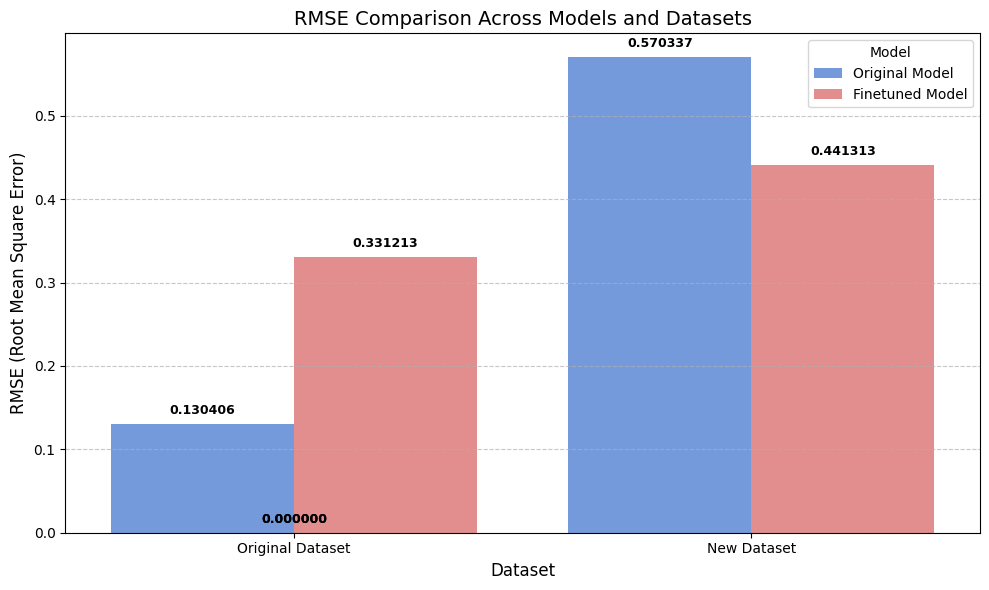


RMSE Values Table:


Model,Finetuned Model,Original Model
Dataset,,
New Dataset,0.441313,0.570337
Original Dataset,0.331213,0.130406


In [7]:
def visualize_rmse_comparison(results):
    """Create a bar chart comparing RMSE values across models and datasets."""
    # Extract data for plotting
    dataset_names = [r['dataset_name'] for r in results]
    model_names = [r['model_name'] for r in results]
    rmse_values = [r['rmse'] for r in results]
    
    # Determine the unique datasets and models
    unique_datasets = list(set(dataset_names))
    unique_models = list(set(model_names))
    
    # Organize data for grouped bar chart
    data = {
        'Dataset': [],
        'Model': [],
        'RMSE': []
    }
    
    for i in range(len(results)):
        data['Dataset'].append(dataset_names[i])
        data['Model'].append(model_names[i])
        data['RMSE'].append(rmse_values[i])
    
    # Create DataFrame
    df = pd.DataFrame(data)
    
    # Create grouped bar chart
    plt.figure(figsize=(10, 6))
    
    # Use seaborn for nicer plots
    ax = sns.barplot(x='Dataset', y='RMSE', hue='Model', data=df, 
                    palette={"Original Model": "cornflowerblue", "Finetuned Model": "lightcoral"})
    
    # Add value labels on top of bars
    for i, p in enumerate(ax.patches):
        ax.annotate(f'{p.get_height():.6f}', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'bottom', fontsize=9, fontweight='bold',
                   xytext = (0, 5), textcoords = 'offset points')
    
    plt.title('RMSE Comparison Across Models and Datasets', fontsize=14)
    plt.xlabel('Dataset', fontsize=12)
    plt.ylabel('RMSE (Root Mean Square Error)', fontsize=12)
    plt.legend(title='Model')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Also display as a table for precise values
    print("\nRMSE Values Table:")
    display(df.pivot(index='Dataset', columns='Model', values='RMSE').round(6))

# Visualize the RMSE comparison if we have results
if results:
    visualize_rmse_comparison(results)
else:
    print("No results available for visualization.")

## 7. Additional Comparison Visualizations

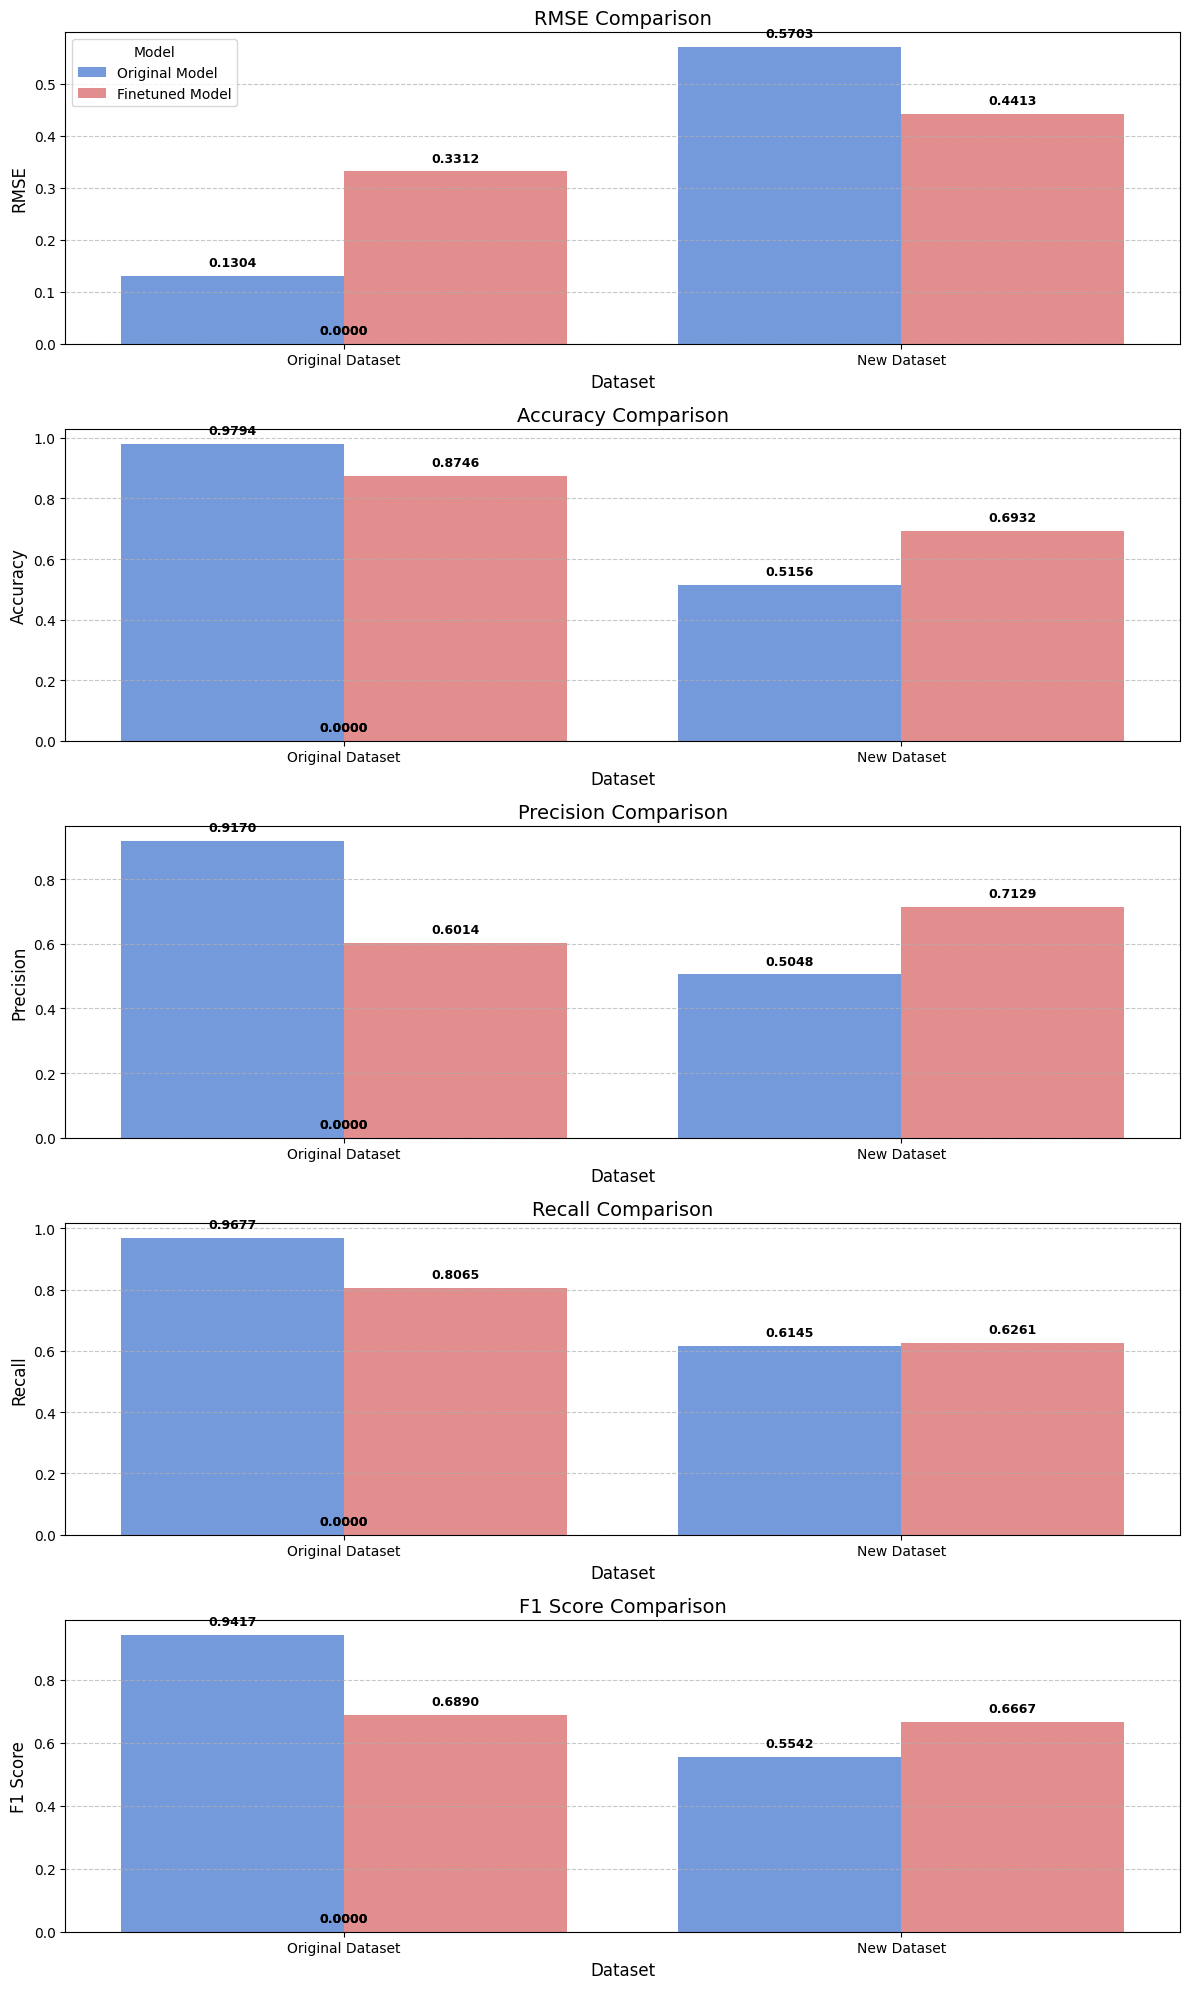

In [8]:
def visualize_metric_comparisons(results):
    """Create bar charts comparing all metrics across models and datasets."""
    # Extract all metrics
    metrics = ['rmse', 'accuracy', 'precision', 'recall', 'f1']
    metric_labels = ['RMSE', 'Accuracy', 'Precision', 'Recall', 'F1 Score']
    
    # Create a figure with subplots for each metric
    fig, axs = plt.subplots(len(metrics), 1, figsize=(12, 4*len(metrics)))
    
    for i, (metric, label) in enumerate(zip(metrics, metric_labels)):
        # Organize data for this metric
        data = {
            'Dataset': [],
            'Model': [],
            'Value': []
        }
        
        for r in results:
            data['Dataset'].append(r['dataset_name'])
            data['Model'].append(r['model_name'])
            data['Value'].append(r[metric])
        
        # Create DataFrame
        df = pd.DataFrame(data)
        
        # Create grouped bar chart for this metric
        sns.barplot(ax=axs[i], x='Dataset', y='Value', hue='Model', data=df, 
                   palette={"Original Model": "cornflowerblue", "Finetuned Model": "lightcoral"})
        
        # Add title and labels
        axs[i].set_title(f'{label} Comparison', fontsize=14)
        axs[i].set_xlabel('Dataset', fontsize=12)
        axs[i].set_ylabel(label, fontsize=12)
        
        # Add value labels on top of bars
        for j, p in enumerate(axs[i].patches):
            axs[i].annotate(f'{p.get_height():.4f}', 
                           (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'bottom', fontsize=9, fontweight='bold',
                           xytext = (0, 5), textcoords = 'offset points')
        
        # Add grid
        axs[i].grid(axis='y', linestyle='--', alpha=0.7)
        
        # Add legend only to the first subplot
        if i == 0:
            axs[i].legend(title='Model')
        else:
            axs[i].get_legend().remove()
    
    plt.tight_layout()
    plt.show()

# Visualize all metrics comparison
if results:
    visualize_metric_comparisons(results)
else:
    print("No results available for metric comparisons.")


--- Class-wise Precision Comparison ---
Original Model on Original Dataset Class Precision:
  - Normal (Class 0): 99.32% precision
  - TB (Class 1): 91.70% precision
Finetuned Model on Original Dataset Class Precision:
  - Normal (Class 0): 95.67% precision
  - TB (Class 1): 60.14% precision
Original Model on New Dataset Class Precision:
  - Normal (Class 0): 53.17% precision
  - TB (Class 1): 50.48% precision
Finetuned Model on New Dataset Class Precision:
  - Normal (Class 0): 67.83% precision
  - TB (Class 1): 71.29% precision


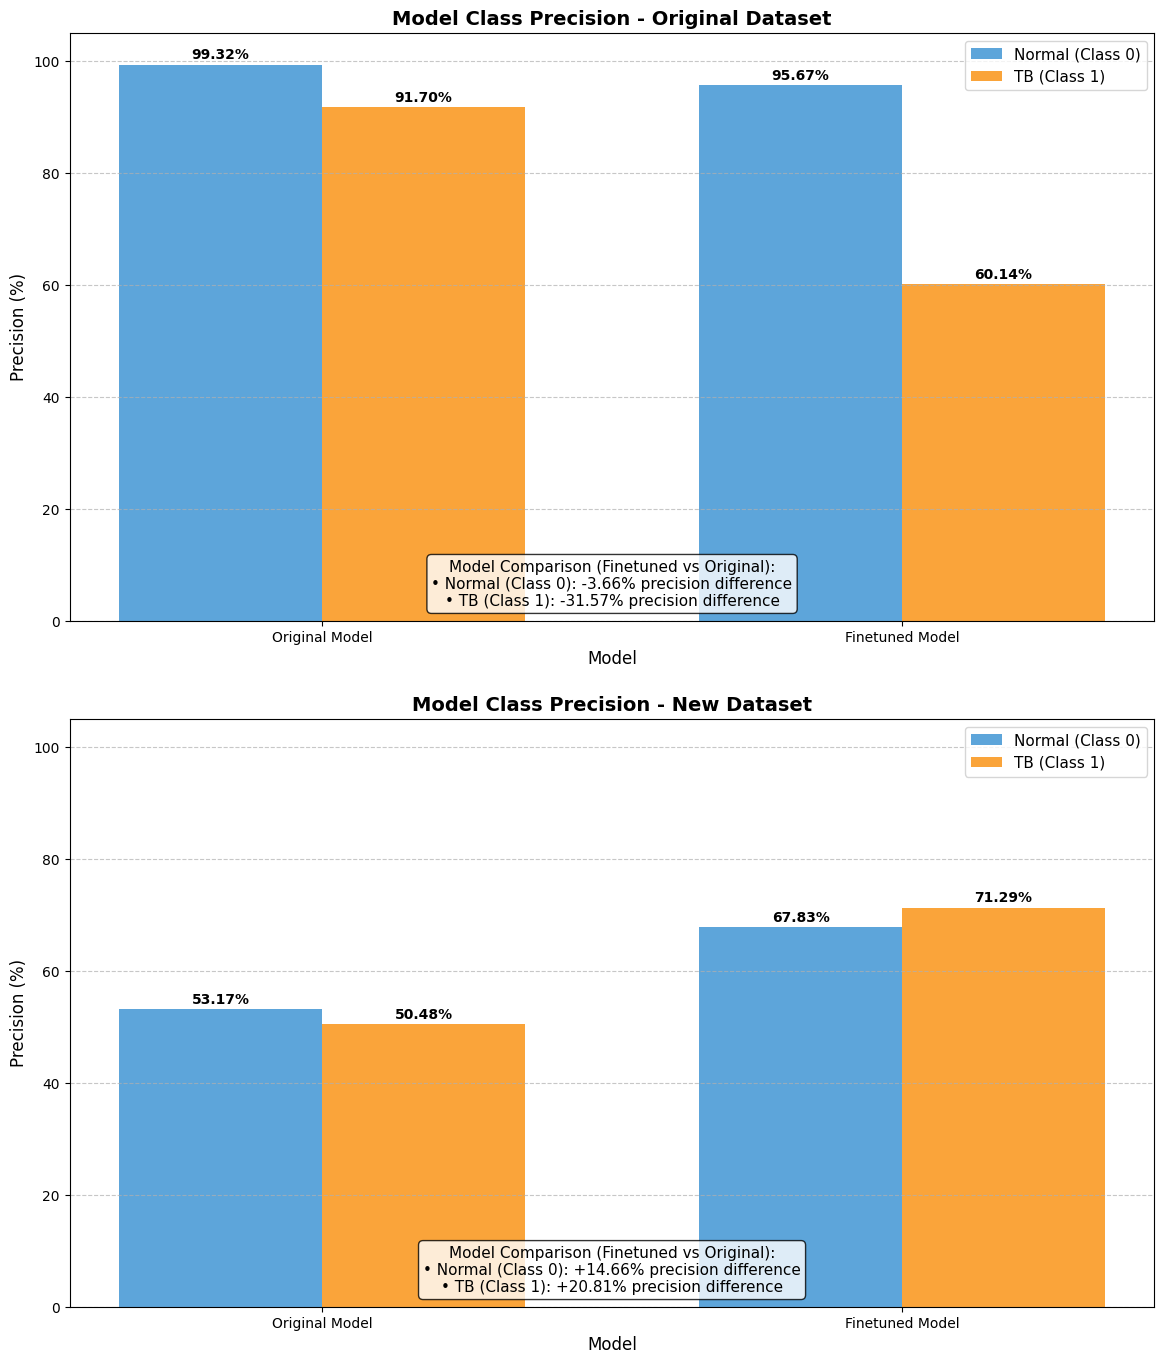

In [10]:
def visualize_class_precision(results):
    """Create bar charts comparing class-wise precision for models across datasets."""
    from sklearn.metrics import precision_score, confusion_matrix
    
    # Group results by dataset
    datasets = set(r['dataset_name'] for r in results)
    
    # Create figure with subplots - one row per dataset
    fig, axs = plt.subplots(len(datasets), 1, figsize=(12, 7*len(datasets)))
    if len(datasets) == 1:
        axs = [axs]  # Make axs iterable for single dataset case
    
    # Process each dataset
    for idx, dataset_name in enumerate(datasets):
        dataset_results = [r for r in results if r['dataset_name'] == dataset_name]
        
        # Create data structures for plotting
        model_names = []
        normal_precision_values = []
        tb_precision_values = []
        
        for r in dataset_results:
            model_name = r['model_name']
            labels = r['labels']
            preds = r['preds']
            
            # Calculate precision for each class
            class_precision = precision_score(labels, preds, average=None) * 100
            normal_precision = class_precision[0]  # Class 0 (Normal)
            tb_precision = class_precision[1]      # Class 1 (TB)
            
            # Store values for plotting
            model_names.append(model_name)
            normal_precision_values.append(normal_precision)
            tb_precision_values.append(tb_precision)
            
            # Print calculated precision values
            print(f"{model_name} on {dataset_name} Class Precision:")
            print(f"  - Normal (Class 0): {normal_precision:.2f}% precision")
            print(f"  - TB (Class 1): {tb_precision:.2f}% precision")
        
        # Set up bar positions
        x = np.arange(len(model_names))
        width = 0.35
        
        # Create grouped bar chart
        ax = axs[idx]
        bars1 = ax.bar(x - width/2, normal_precision_values, width, label='Normal (Class 0)', color='#5DA5DA')
        bars2 = ax.bar(x + width/2, tb_precision_values, width, label='TB (Class 1)', color='#FAA43A')
        
        # Add percentage labels on bars
        for bar in bars1:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                   f'{height:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=10)
        
        for bar in bars2:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                   f'{height:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=10)
        
        # Add labels and title
        ax.set_xlabel('Model', fontsize=12)
        ax.set_ylabel('Precision (%)', fontsize=12)
        ax.set_title(f'Model Class Precision - {dataset_name}', fontsize=14, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(model_names)
        ax.set_ylim(0, 105)  # Set y-axis limit to accommodate text labels
        ax.legend(fontsize=11)
        
        # Add grid lines for better readability
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Add text box with model comparison
        if len(model_names) == 2:  # If we have both models for comparison
            normal_diff = normal_precision_values[1] - normal_precision_values[0]
            tb_diff = tb_precision_values[1] - tb_precision_values[0]
            
            normal_sign = '+' if normal_diff > 0 else ''
            tb_sign = '+' if tb_diff > 0 else ''
            
            textstr = '\n'.join([
                'Model Comparison (Finetuned vs Original):',
                f'• Normal (Class 0): {normal_sign}{normal_diff:.2f}% precision difference',
                f'• TB (Class 1): {tb_sign}{tb_diff:.2f}% precision difference'
            ])
            
            props = dict(boxstyle='round', facecolor='white', alpha=0.8)
            ax.text(0.5, 0.02, textstr, transform=ax.transAxes, 
                   fontsize=11, verticalalignment='bottom', horizontalalignment='center',
                   bbox=props)
    
    plt.tight_layout(pad=2)
    plt.show()

# Visualize class-wise precision comparison
if results:
    print("\n--- Class-wise Precision Comparison ---")
    visualize_class_precision(results)
else:
    print("No results available for class precision visualization.")